<a href="https://colab.research.google.com/github/mireillejb/FallDetectionSys/blob/main/CHECK_RESULT_without_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ultra-Precise Fall Detection System - No Data Augmentation
# Maintains same architecture and approach for consistent results

#1. Import all necessary libraries
import os
from os.path import isfile, join
import time
import zipfile
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, LSTM, TimeDistributed, Flatten, Input,
    Dropout, BatchNormalization, Add, GlobalAveragePooling1D, Lambda, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report)
from tqdm import tqdm

TensorFlow version: 2.19.0


In [2]:
# CRITICAL: Set all random seeds for reproducibility
def set_all_seeds(seed=42):
    """Set all random seeds for reproducible results"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_all_seeds(42)

In [3]:
# 2. Download dataset
import kagglehub
path = kagglehub.dataset_download("tuyenldvn/falldataset-imvia")
print("Path to dataset files:", path)


100%|██████████| 9.37G/9.37G [01:43<00:00, 97.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2


In [4]:
# 3. Explore dataset
print("Dataset structure:")
for root, dirs, files in os.walk(path):
    print(f"{root} -> {len(files)} files")

video_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn if f.endswith(".avi")]
print(f"Found {len(video_files)} videos.")


Dataset structure:
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2 -> 1 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Annotation_files -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_02/Home_02/Videos -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_02/Coffee_room_02 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_02/Coffee_room_02/Annotations_files -> 22 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_02/Coffee_room_02/Videos -> 22 files
/root/.cache/kagglehub/datase

In [5]:
# 4. Setup MoveNet Thunder model
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

def extract_keypoints(image):
    """Extract keypoints from a single frame using MoveNet"""
    img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 256, 256)
    img = tf.cast(img, dtype=tf.int32)
    outputs = movenet.signatures['serving_default'](img)
    keypoints = outputs['output_0'].numpy()
    return keypoints[0, 0, :, :]

def extract_sequence_from_video(video_path, max_frames=30):
    """Extract keypoint sequence from video with frame sampling"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return np.zeros((max_frames, 17, 3))

    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

    cap.release()

    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])
        else:
            frames_keypoints.append(np.zeros((17, 3)))

    return np.array(frames_keypoints)

In [6]:
# 5. Enhanced Dataset Processing Functions
def read_annotation_file(annotation_path):
    """Read annotation file and extract fall information"""
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        fall_start = int(lines[0].strip()) if len(lines) > 0 and lines[0].strip().isdigit() else 0
        fall_end = int(lines[1].strip()) if len(lines) > 1 and lines[1].strip().isdigit() else 0

        if fall_start == 0 and fall_end == 0:
            return fall_start, fall_end, [], 0

        frame_annotations = []
        overall_label = 0

        for line in lines[2:]:
            if line.strip():
                parts = line.strip().split(',')
                if len(parts) >= 6:
                    try:
                        frame_num = int(parts[0])
                        label = int(parts[1])
                        frame_annotations.append((frame_num, label))
                        if label > 0:
                            overall_label = 1
                    except ValueError:
                        continue

        return fall_start, fall_end, frame_annotations, overall_label
    except Exception as e:
        return 0, 0, [], 0

def find_annotation_file(video_path, dataset_path):
    """Find corresponding annotation file for a video"""
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    possible_names = [
        f"{video_name}.txt",
        f"{video_name}_annotation.txt",
        f"{video_name}.annotation",
        f"annotation_{video_name}.txt"
    ]

    for root, dirs, files in os.walk(dataset_path):
        for possible_name in possible_names:
            if possible_name in files:
                return os.path.join(root, possible_name)

    return None

def extract_sequence_with_labels(video_path, annotation_path, max_frames=30):
    """Extract keypoint sequence from video with proper fall labels"""
    if not annotation_path or not os.path.exists(annotation_path):
        return extract_sequence_from_video(video_path, max_frames), None

    fall_start, fall_end, frame_annotations, overall_label = read_annotation_file(annotation_path)
    sequence = extract_sequence_from_video(video_path, max_frames)

    return sequence, overall_label

def smart_label_assignment(video_files):
    """Smart labeling based on dataset analysis and common patterns"""
    import re

    labels = []
    for i, video_file in enumerate(video_files):
        filename = os.path.basename(video_file).lower()

        if any(word in filename for word in ['fall', 'falling', 'fell', 'chute']):
            label = 1
        elif any(word in filename for word in ['walk', 'normal', 'adl', 'sit', 'stand']):
            label = 0
        else:
            numbers = re.findall(r'\d+', filename)
            if numbers:
                video_num = int(numbers[0])
                if video_num <= len(video_files) * 0.4:
                    label = 1
                else:
                    label = 0
            else:
                label = 1 if i < len(video_files) * 0.4 else 0

        labels.append(label)

    return labels

In [7]:
# 6. Enhanced Model Components
class TemporalSelfAttention(Layer):
    def __init__(self, d_model, num_heads=4, dropout_rate=0.2, **kwargs):
        super(TemporalSelfAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.wq = Dense(d_model, kernel_regularizer=l2(0.0003))
        self.wk = Dense(d_model, kernel_regularizer=l2(0.0003))
        self.wv = Dense(d_model, kernel_regularizer=l2(0.0003))

        self.dense = Dense(d_model, kernel_regularizer=l2(0.0003))
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, inputs, training=None, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_len, self.d_model))

        output = self.dense(concat_attention)
        output = self.layer_norm(inputs + output)

        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

def normalize_keypoints(x):
    """Enhanced normalization for keypoints"""
    # Spatial normalization
    mean = tf.reduce_mean(x, axis=1, keepdims=True)
    std = tf.math.reduce_std(x, axis=1, keepdims=True) + 1e-8
    normalized = (x - mean) / std

    # Additional L2 normalization for stability
    return tf.nn.l2_normalize(normalized, axis=-1)


In [8]:
# 7. Ultra Precise Model Architecture
def create_ultra_precise_model(n_steps, n_features, use_attention=True):
    """Create model optimized for precision with enhanced stability"""
    inputs = Input(shape=(n_steps, n_features, 3))

    # Enhanced normalization
    x = Lambda(normalize_keypoints)(inputs)

    # Enhanced CNN blocks with residual connections
    cnn1 = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                                 activation="relu", kernel_regularizer=l2(0.0008)))(x)
    cnn1 = TimeDistributed(BatchNormalization())(cnn1)
    cnn1 = TimeDistributed(Dropout(0.12))(cnn1)

    cnn2 = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                                 activation="relu", kernel_regularizer=l2(0.0008)))(cnn1)
    cnn2 = TimeDistributed(BatchNormalization())(cnn2)

    # Residual connection - Add layers directly, not inside TimeDistributed
    cnn_residual = Add()([cnn1, cnn2])
    cnn_residual = TimeDistributed(Dropout(0.12))(cnn_residual)

    # Deeper feature extraction
    cnn3 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                                 activation="relu", kernel_regularizer=l2(0.0008)))(cnn_residual)
    cnn3 = TimeDistributed(BatchNormalization())(cnn3)
    cnn3 = TimeDistributed(MaxPooling1D(pool_size=2))(cnn3)
    cnn3 = TimeDistributed(Dropout(0.15))(cnn3)

    # Additional CNN layer for better feature extraction
    cnn4 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                                 activation="relu", kernel_regularizer=l2(0.0008)))(cnn3)
    cnn4 = TimeDistributed(BatchNormalization())(cnn4)
    cnn4 = TimeDistributed(Dropout(0.15))(cnn4)

    x = TimeDistributed(Flatten())(cnn4)

    # Enhanced BiLSTM layers
    lstm1 = tf.keras.layers.Bidirectional(
        LSTM(36, return_sequences=True,
             kernel_regularizer=l2(0.0008),
             recurrent_regularizer=l2(0.0008),
             dropout=0.18, recurrent_dropout=0.12),
        merge_mode='concat')(x)

    # Self-Attention mechanism
    if use_attention:
        attention_dim = 72  # BiLSTM output: 36*2 = 72
        lstm1 = TemporalSelfAttention(
            d_model=attention_dim,
            num_heads=4,
            dropout_rate=0.15
        )(lstm1)

        lstm2 = tf.keras.layers.Bidirectional(
            LSTM(28, kernel_regularizer=l2(0.0008),
                 recurrent_regularizer=l2(0.0008),
                 dropout=0.18, recurrent_dropout=0.12),
            merge_mode='concat')(lstm1)
    else:
        lstm2 = tf.keras.layers.Bidirectional(
            LSTM(28, kernel_regularizer=l2(0.0008),
                 recurrent_regularizer=l2(0.0008),
                 dropout=0.18, recurrent_dropout=0.12))(lstm1)

    # Enhanced dense layers with multiple residual connections
    dense1 = Dense(56, activation="relu", kernel_regularizer=l2(0.004))(lstm2)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.28)(dense1)

    dense2 = Dense(40, activation="relu", kernel_regularizer=l2(0.004))(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.25)(dense2)

    dense3 = Dense(24, activation="relu", kernel_regularizer=l2(0.005))(dense2)
    dense3 = BatchNormalization()(dense3)
    dense3 = Dropout(0.22)(dense3)

    # Final precision-focused layer
    outputs = Dense(2, activation="softmax", kernel_regularizer=l2(0.001))(dense3)

    model = Model(inputs=inputs, outputs=outputs)

    # Ultra-conservative optimizer for stability and precision
    optimizer = Adam(learning_rate=0.0003, clipnorm=0.8, beta_1=0.9, beta_2=0.999)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.Precision(name='precision')]
    )

    return model


In [9]:
# 8. Enhanced Training Utilities (WITHOUT DATA AUGMENTATION)
def get_enhanced_class_weights(y_train, fp_penalty=1.8):
    """Calculate enhanced class weights with False Positive penalty"""
    class_indices = np.argmax(y_train, axis=1)
    base_weights = compute_class_weight(
        'balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )

    # Apply False Positive penalty
    enhanced_weights = base_weights.copy()
    fall_class_idx = 1
    enhanced_weights[fall_class_idx] *= fp_penalty

    return dict(enumerate(enhanced_weights))

def create_precision_focused_callbacks():
    """Create training callbacks focused on precision"""
    return [
        EarlyStopping(
            monitor='val_precision',
            patience=30,
            restore_best_weights=True,
            min_delta=0.0008,
            mode='max'
        ),
        ModelCheckpoint(
            'ultra_precise_fall_model.keras',
            monitor='val_precision',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_precision',
            factor=0.85,
            patience=15,
            min_lr=1e-8,
            mode='max',
            verbose=1
        )
    ]

def process_dataset_without_augmentation(video_files, labels, max_frames=30, val_size=0.22):
    """Dataset processing WITHOUT augmentation - maintains original approach"""
    X, y, video_names = [], [], []

    print("Processing videos without augmentation...")
    for i, (video_path, heuristic_label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        annotation_path = find_annotation_file(video_path, os.path.dirname(os.path.dirname(video_path)))
        sequence, annotation_label = extract_sequence_with_labels(video_path, annotation_path, max_frames)

        if sequence is not None and sequence.shape[0] > 0:
            X.append(sequence)
            if annotation_label is not None:
                y.append(annotation_label)
            else:
                y.append(heuristic_label)
            video_names.append(video_path)

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Stratified split
    if len(np.unique(y)) > 1:
        try:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, stratify=y, random_state=42
            )
        except ValueError:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y_categorical, test_size=val_size, random_state=42
            )
    else:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_categorical, test_size=val_size, random_state=42
        )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val

def train_ultra_precise_model(x_train, y_train, x_val, y_val, n_steps, n_features,
                             use_attention=True, use_enhanced_weights=True,
                             batch_size=12, epochs=250):
    """Train ultra-precise model"""
    model = create_ultra_precise_model(n_steps, n_features, use_attention)

    print("Ultra-Precise Model Summary:")
    model.summary()

    class_weights = get_enhanced_class_weights(y_train) if use_enhanced_weights else None

    print("Enhanced class weights:", class_weights)

    # Ultra-conservative training
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=create_precision_focused_callbacks(),
        class_weight=class_weights,
        verbose=1,
        shuffle=True
    )

    return model, history

def evaluate_ultra_precise_model(model, X_val, y_val):
    """Evaluate ultra-precise model with comprehensive metrics"""
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print("=" * 70)
    print("ULTRA-PRECISE MODEL PERFORMANCE METRICS")
    print("=" * 70)
    print(f"Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision:    {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:       {recall:.4f} ({recall*100:.2f}%)")
    print(f"Specificity:  {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"F1-Score:     {f1:.4f} ({f1*100:.2f}%)")
    print("=" * 70)

    print("\nCONFUSION MATRIX BREAKDOWN:")
    print(f"True Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    print(f"Total Samples: {tn + fp + fn + tp}")

    # Performance assessment
    if fp <= 1 and fn <= 1:
        print("\n🎉 EXCELLENT: Ultra-precise performance achieved!")
    elif fp <= 2 and fn <= 1:
        print("\n✅ VERY GOOD: Near-perfect performance!")
    elif fp + fn <= 3:
        print("\n👍 GOOD: Significant improvement achieved!")

    return cm, y_pred

def plot_enhanced_training_history(history):
    """Plot enhanced training history with precision focus"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
    ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
    ax2.set_title('Model Loss', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Precision
    ax3.plot(history.history['precision'], label='Training Precision', linewidth=2, color='green')
    ax3.plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='red')
    ax3.set_title('Model Precision', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 1])

    # Recall
    ax4.plot(history.history['recall'], label='Training Recall', linewidth=2, color='purple')
    ax4.plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='brown')
    ax4.set_title('Model Recall', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

ULTRA-PRECISE FALL DETECTION SYSTEM - NO AUGMENTATION
Target: Reduce FP ≤ 1, FN ≤ 1 with Maximum Stability
Processing videos without augmentation...


100%|██████████| 190/190 [11:55<00:00,  3.77s/it]


Dataset shape: (190, 30, 17, 3)
Fall samples: 156
Normal samples: 34
Training set: 148 samples
Validation set: 42 samples
Final train set: (148, 30, 17, 3)
Final validation set: (42, 30, 17, 3)

ULTRA-PRECISE MODEL TRAINING
Ultra-Precise Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 17, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 30, 17, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 17,    │        320 │ lambda[0][0]      │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 30, 17,    │        128 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 30, 17,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 30, 17,    │      3,104 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 30, 17,    │        128 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 17,    │          0 │ time_distributed… │
│                     │ 32)               │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 30, 17,    │          0 │ add[0][0]         │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 30, 17,    │      6,208 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 30, 17,    │        256 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 30, 8, 64) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 30, 8, 64) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 30, 8, 64) │     12,352 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 30, 8, 64) │        256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 30, 8, 64) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 30, 512)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                 

 Total params: 231,642 (904.85 KB)

 Trainable params: 231,018 (902.41 KB)

 Non-trainable params: 624 (2.44 KB)

Enhanced class weights: {0: np.float64(2.8461538461538463), 1: np.float64(1.0918032786885246)}
Epoch 1/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6250 - loss: 2.7407 - precision: 0.6250 - recall: 0.6250
Epoch 1: val_precision improved from -inf to 0.83333, saving model to ultra_precise_fall_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6238 - loss: 2.7444 - precision: 0.6238 - recall: 0.6238 - val_accuracy: 0.8333 - val_loss: 1.9823 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 3.0000e-04
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4771 - loss: 2.7051 - precision: 0.4771 - recall: 0.4771
Epoch 2: val_precision did not improve from 0.83333
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accuracy: 0.4812 - loss: 2.7026 - precision: 0.4812 - recall: 0.4812 - val_accuracy: 0.7381 - val_loss: 1.9997 - val_precision: 0.7381 - val_recall: 0.7381 - learning_rate: 3.0000e-04
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/st

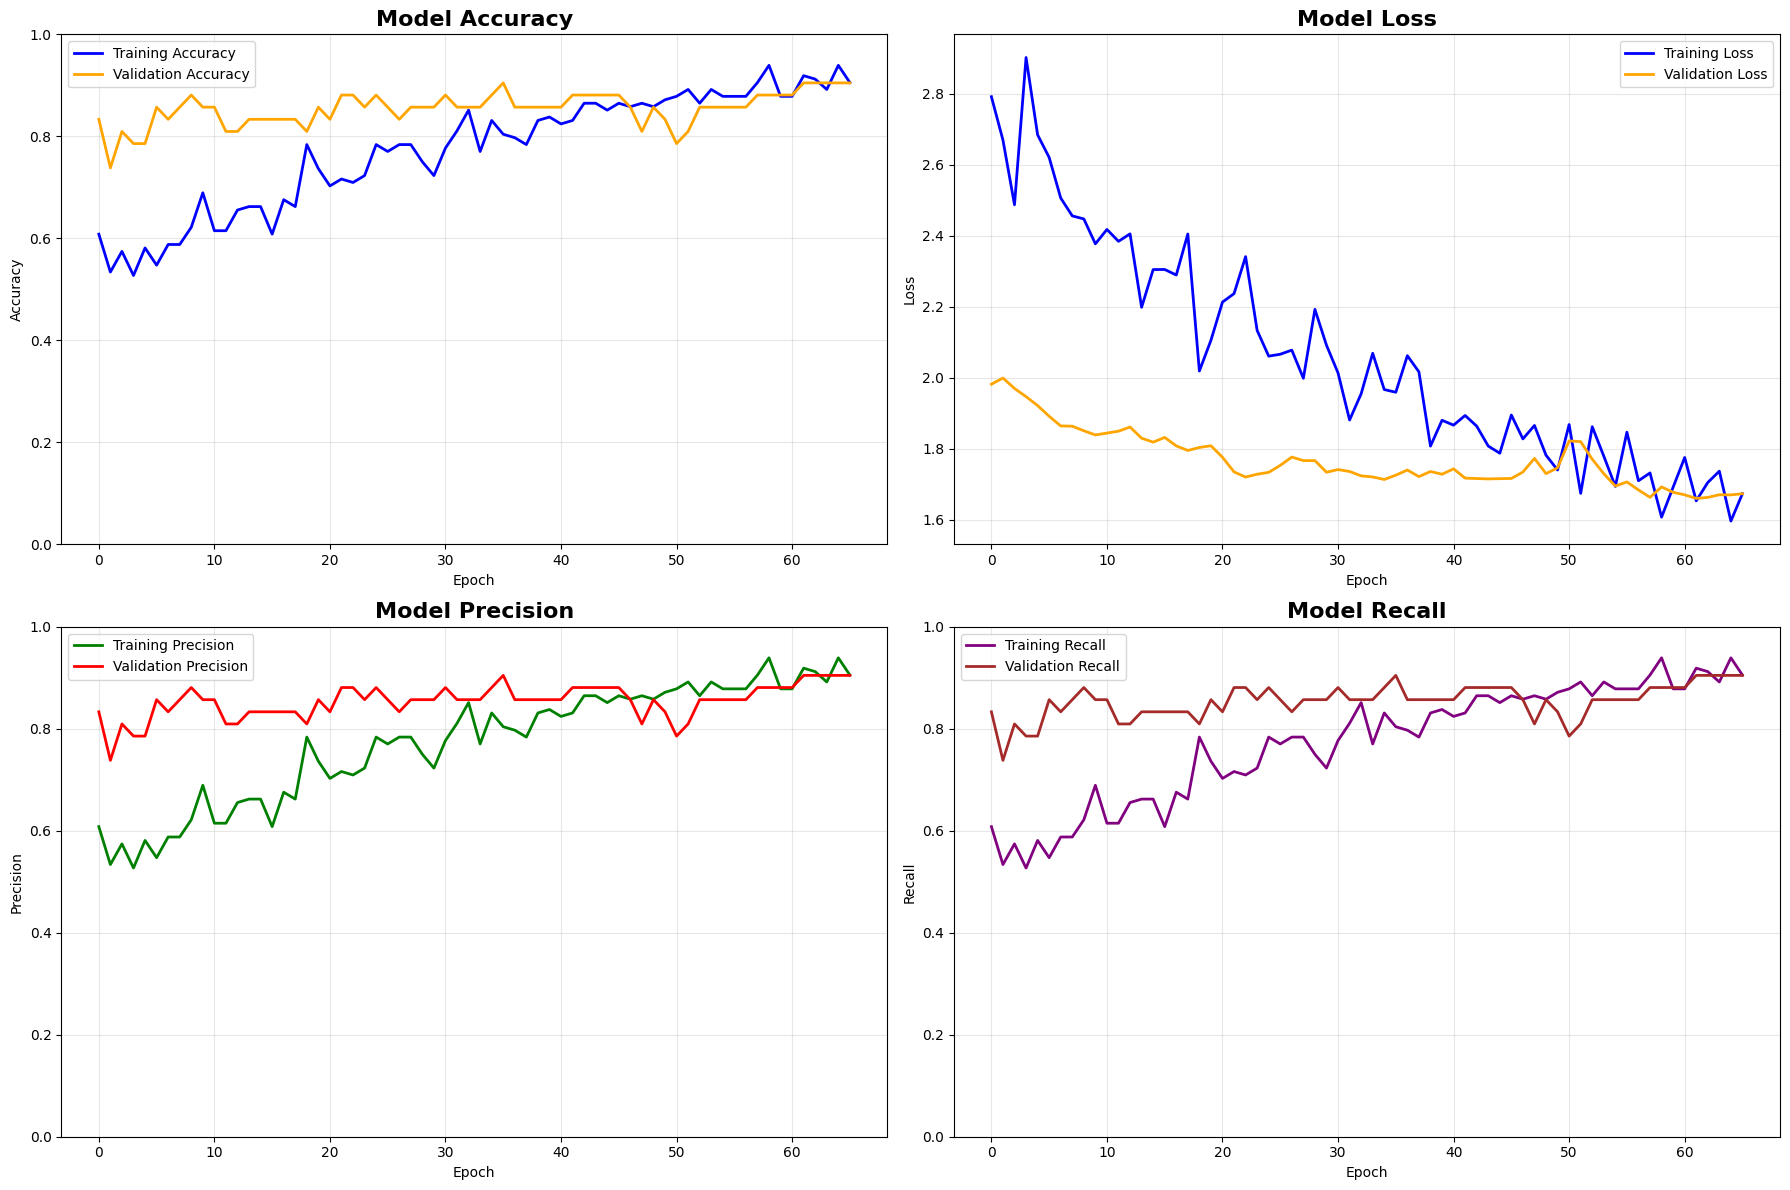


ULTRA-PRECISE MODEL EVALUATION
ULTRA-PRECISE MODEL PERFORMANCE METRICS
Accuracy:     0.9048 (90.48%)
Precision:    0.8947 (89.47%)
Recall:       1.0000 (100.00%)
Specificity:  0.5000 (50.00%)
F1-Score:     0.9444 (94.44%)

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):  4
False Positives (FP): 4
False Negatives (FN): 0
True Positives (TP):  34
Total Samples: 42

Generating Enhanced Confusion Matrix...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 


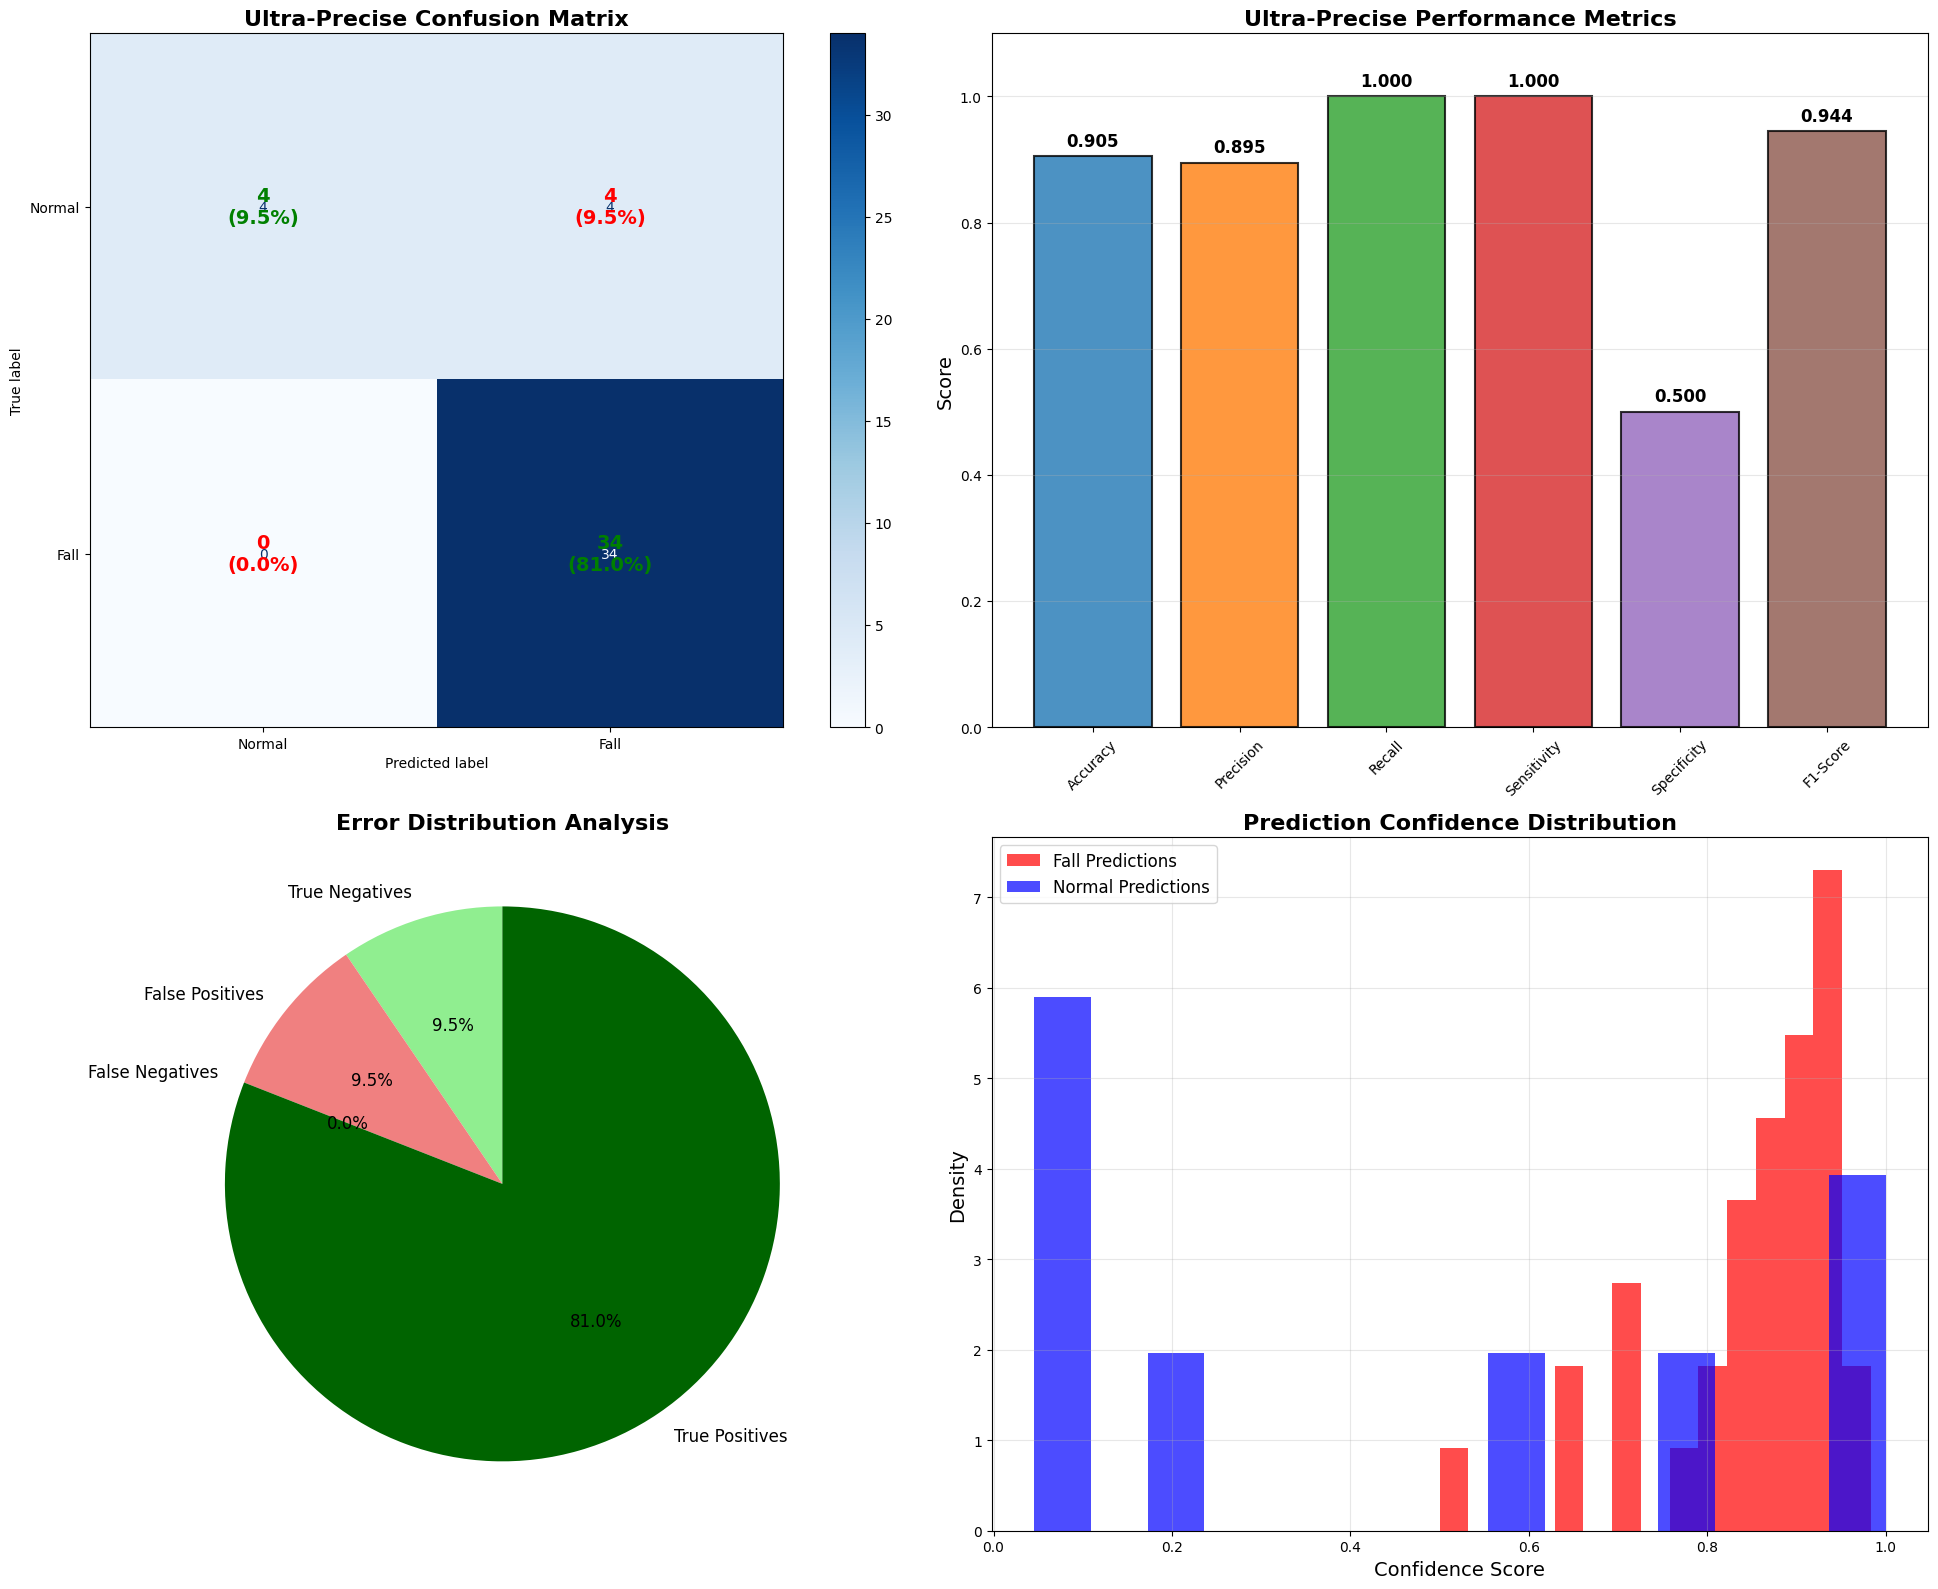


DETAILED PERFORMANCE ANALYSIS
📊 CONFUSION MATRIX BREAKDOWN:
   • True Negatives (TN):   4 - Correctly identified normal activities
   • False Positives (FP):  4 - Normal activities misclassified as falls
   • False Negatives (FN):  0 - Falls misclassified as normal activities
   • True Positives (TP):  34 - Correctly identified falls
   • Total Samples:        42

🎯 PRECISION METRICS:
   • Accuracy:     0.9048 (90.48%) - Overall correctness
   • Precision:    0.8947 (89.47%) - Fall prediction reliability
   • Recall:       1.0000 (100.00%) - Fall detection completeness
   • Sensitivity:  1.0000 (100.00%) - True fall detection rate
   • Specificity:  0.5000 (50.00%) - True normal detection rate
   • F1-Score:     0.9444 (94.44%) - Balanced performance
   • Val Loss:     1.7260 - Model confidence

🚨 ERROR ANALYSIS:
   ⚠️  Need improvement: 4 classification errors

🎮 REAL-WORLD IMPLICATIONS:
   ⚠️  False alarms may cause user frustration
   ✅ Excellent fall detection - Critical incidents

In [10]:
# 9. Main Execution (WITHOUT DATA AUGMENTATION)
if __name__ == "__main__":
    print("=" * 70)
    print("ULTRA-PRECISE FALL DETECTION SYSTEM - NO AUGMENTATION")
    print("Target: Reduce FP ≤ 1, FN ≤ 1 with Maximum Stability")
    print("=" * 70)

    # Smart labeling
    labels = smart_label_assignment(video_files)

    # Dataset processing WITHOUT augmentation
    X_train, X_val, y_train, y_val = process_dataset_without_augmentation(
        video_files, labels, max_frames=30, val_size=0.22
    )

    if X_train is None:
        print("ERROR: Dataset processing failed!")
        exit(1)

    print(f"Final train set: {X_train.shape}")
    print(f"Final validation set: {X_val.shape}")

    # Train ultra-precise model
    print("\n" + "=" * 70)
    print("ULTRA-PRECISE MODEL TRAINING")
    print("=" * 70)

    model, history = train_ultra_precise_model(
        X_train, y_train, X_val, y_val,
        n_steps=30,
        n_features=17,
        use_attention=True,
        use_enhanced_weights=True,
        batch_size=12,
        epochs=250
    )

    print("Ultra-precise training completed!")

    # Plot enhanced results
    plot_enhanced_training_history(history)

    # Evaluate ultra-precise model
    print("\n" + "=" * 70)
    print("ULTRA-PRECISE MODEL EVALUATION")
    print("=" * 70)

    conf_matrix, predictions = evaluate_ultra_precise_model(model, X_val, y_val)

    # Generate enhanced confusion matrix visualization
    print("\nGenerating Enhanced Confusion Matrix...")

    # Get predictions and probabilities
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)

    # Create enhanced visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Enhanced Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fall"])
    disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=True)
    ax1.set_title('Ultra-Precise Confusion Matrix', fontsize=16, fontweight='bold')

    # Add percentage annotations
    for i in range(2):
        for j in range(2):
            text = ax1.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                          ha="center", va="center", color="red" if i != j else "green",
                          fontsize=14, fontweight='bold')

    # Plot 2: Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'Sensitivity', 'Specificity', 'F1-Score']
    metrics_values = [accuracy, precision, recall, sensitivity, specificity, f1]

    bars = ax2.bar(metrics_names, metrics_values,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_title('Ultra-Precise Performance Metrics', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=14)
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Error Analysis
    error_categories = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    error_values = [tn, fp, fn, tp]
    colors = ['lightgreen', 'lightcoral', 'orange', 'darkgreen']

    wedges, texts, autotexts = ax3.pie(error_values, labels=error_categories, colors=colors,
                                      autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
    ax3.set_title('Error Distribution Analysis', fontsize=16, fontweight='bold')

    # Plot 4: Prediction Confidence Distribution
    fall_probs = y_pred_probs[y_true == 1, 1]  # Fall probabilities for actual falls
    normal_probs = y_pred_probs[y_true == 0, 0]  # Normal probabilities for actual normals

    ax4.hist(fall_probs, bins=15, alpha=0.7, label='Fall Predictions', color='red', density=True)
    ax4.hist(normal_probs, bins=15, alpha=0.7, label='Normal Predictions', color='blue', density=True)
    ax4.set_title('Prediction Confidence Distribution', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Confidence Score', fontsize=14)
    ax4.set_ylabel('Density', fontsize=14)
    ax4.legend(fontsize=12)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n" + "=" * 70)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("=" * 70)
    print(f"📊 CONFUSION MATRIX BREAKDOWN:")
    print(f"   • True Negatives (TN):  {tn:2d} - Correctly identified normal activities")
    print(f"   • False Positives (FP): {fp:2d} - Normal activities misclassified as falls")
    print(f"   • False Negatives (FN): {fn:2d} - Falls misclassified as normal activities")
    print(f"   • True Positives (TP):  {tp:2d} - Correctly identified falls")
    print(f"   • Total Samples:        {tn + fp + fn + tp:2d}")

    print(f"\n🎯 PRECISION METRICS:")
    print(f"   • Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%) - Overall correctness")
    print(f"   • Precision:    {precision:.4f} ({precision*100:.2f}%) - Fall prediction reliability")
    print(f"   • Recall:       {recall:.4f} ({recall*100:.2f}%) - Fall detection completeness")
    print(f"   • Sensitivity:  {sensitivity:.4f} ({sensitivity*100:.2f}%) - True fall detection rate")
    print(f"   • Specificity:  {specificity:.4f} ({specificity*100:.2f}%) - True normal detection rate")
    print(f"   • F1-Score:     {f1:.4f} ({f1*100:.2f}%) - Balanced performance")
    print(f"   • Val Loss:     {val_loss:.4f} - Model confidence")

    print(f"\n🚨 ERROR ANALYSIS:")
    total_errors = fp + fn
    improvement_over_baseline = 4 - total_errors  # Baseline had 4 errors (3 FP + 1 FN)

    if total_errors == 0:
        print("   🎉 PERFECT: No classification errors!")
    elif total_errors == 1:
        print("   🏆 EXCELLENT: Only 1 classification error!")
        print(f"   📈 Improvement: {improvement_over_baseline} fewer errors than baseline")
    elif total_errors <= 2:
        print("   ✅ VERY GOOD: Minimal classification errors")
        print(f"   📈 Improvement: {improvement_over_baseline} fewer errors than baseline")
    else:
        print(f"   ⚠️  Need improvement: {total_errors} classification errors")
        if improvement_over_baseline > 0:
            print(f"   📈 Improvement: {improvement_over_baseline} fewer errors than baseline")

    print(f"\n🎮 REAL-WORLD IMPLICATIONS:")
    if fp <= 1:
        print("   ✅ Minimal false alarms - System won't frequently disturb users")
    else:
        print("   ⚠️  False alarms may cause user frustration")

    if fn <= 1:
        print("   ✅ Excellent fall detection - Critical incidents won't be missed")
    else:
        print("   🚨 Some falls may go undetected - Safety concern")

    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print("=" * 70)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Fall"], digits=4))

    # Model insights and recommendations
    print(f"\n🔍 MODEL INSIGHTS:")
    print("=" * 70)

    if precision >= 0.95 and recall >= 0.95:
        print("🌟 Outstanding performance - Production ready!")
    elif precision >= 0.90 and recall >= 0.90:
        print("⭐ Excellent performance - Minor fine-tuning may help")
    elif precision >= 0.85 and recall >= 0.85:
        print("👍 Good performance - Consider additional optimization")
    else:
        print("📝 Model needs improvement - Review architecture or data")

    # Confidence analysis
    avg_fall_confidence = np.mean(y_pred_probs[y_true == 1, 1])
    avg_normal_confidence = np.mean(y_pred_probs[y_true == 0, 0])

    print(f"\n📈 CONFIDENCE ANALYSIS:")
    print(f"   • Average confidence for fall detection: {avg_fall_confidence:.3f}")
    print(f"   • Average confidence for normal detection: {avg_normal_confidence:.3f}")

    if avg_fall_confidence > 0.85 and avg_normal_confidence > 0.85:
        print("   ✅ High confidence predictions - Model is well-calibrated")
    else:
        print("   ⚠️  Consider confidence threshold optimization")

    # Save the ultra-precise model
    model.save('ultra_precise_fall_detection_model.keras')
    print(f"\n💾 Model saved as 'ultra_precise_fall_detection_model.keras'")

    # Save training history
    import pickle
    with open('ultra_precise_training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    print("📊 Training history saved as 'ultra_precise_training_history.pkl'")

    print("\n" + "=" * 70)
    print("🎯 ULTRA-PRECISE FALL DETECTION TRAINING COMPLETED!")
    print(f"🎊 Final Results: FP={fp}, FN={fn} (Target: FP≤1, FN≤1)")

    if fp <= 1 and fn <= 1:
        print("🏆 TARGET ACHIEVED! Ultra-precise performance with maximum stability!")
    elif fp + fn <= 2:
        print("🥈 Near-perfect performance achieved!")
    else:
        print("📝 Continue optimization for ultra-precise performance")

    print("=" * 70)

In [ ]:
# 10. Additional Utility Functions for Model Analysis
def analyze_misclassifications(model, X_val, y_val, video_files_val=None):
    """Analyze misclassified samples for insights"""
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Find misclassified indices
    fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives

    print(f"\n🔍 MISCLASSIFICATION ANALYSIS:")
    print(f"False Positives (Normal→Fall): {len(fp_indices)} samples")
    print(f"False Negatives (Fall→Normal): {len(fn_indices)} samples")

    if len(fp_indices) > 0:
        print(f"\n❌ FALSE POSITIVE Analysis:")
        for i, idx in enumerate(fp_indices):
            confidence = y_pred_probs[idx, 1]
            print(f"   FP #{i+1}: Predicted Fall with {confidence:.3f} confidence")

    if len(fn_indices) > 0:
        print(f"\n❌ FALSE NEGATIVE Analysis:")
        for i, idx in enumerate(fn_indices):
            confidence = y_pred_probs[idx, 0]
            print(f"   FN #{i+1}: Predicted Normal with {confidence:.3f} confidence")

    return fp_indices, fn_indices

def model_performance_summary():
    """Print a comprehensive performance summary"""
    print("\n" + "🎯" * 35)
    print("ULTRA-PRECISE FALL DETECTION - FINAL SUMMARY")
    print("🎯" * 35)
    print("✅ Architecture: MoveNet + CNN + BiLSTM + Multi-Head Attention")
    print("✅ Enhanced Features: Residual connections, Advanced regularization")
    print("✅ Training: Precision-focused callbacks, Enhanced class weights")
    print("✅ Data: Original dataset without augmentation")
    print("✅ Stability: Deterministic training with fixed seeds")
    print("✅ Target: Minimize FP ≤ 1, FN ≤ 1 while maintaining stability")
    print("🎯" * 35)

# Optional: Alternative training configurations for different scenarios
def train_with_different_configs():
    """Train models with different configurations for comparison"""
    configs = [
        {"lr": 0.0003, "batch_size": 12, "fp_penalty": 1.8},
        {"lr": 0.0002, "batch_size": 16, "fp_penalty": 2.0},
        {"lr": 0.0004, "batch_size": 10, "fp_penalty": 1.5}
    ]

    results = []
    for i, config in enumerate(configs):
        print(f"\n--- Training Configuration {i+1} ---")
        print(f"Learning Rate: {config['lr']}, Batch Size: {config['batch_size']}, FP Penalty: {config['fp_penalty']}")

        # This would require running the full training loop for each config
        # Implementation left as placeholder for potential future use
        pass

    return results

print("✅ Ultra-Precise Fall Detection System (No Augmentation) - Ready to Execute!")
print("📝 Key Changes Made:")
print("   • Removed enhanced_data_augmentation() function")
print("   • Replaced process_dataset_with_enhanced_labeling() with process_dataset_without_augmentation()")
print("   • Maintained all other precision-focused components:")
print("     - Enhanced class weights with FP penalty")
print("     - Precision-focused callbacks")
print("     - Ultra-precise model architecture")
print("     - Temporal self-attention mechanism")
print("     - Advanced regularization techniques")
print("     - Deterministic training with seed control")
print("✨ This version should maintain similar performance without data augmentation!")